In [1]:
using Plots
using Random: MersenneTwister
using StatsBase: mean

include("../src/Simulation.jl")
using .Simulation: Param, Model, C_rate, resource_allocation!, simple_strategy_update!

include("../src/ColorScheme.jl")
using .ColorScheme
const CS = ColorScheme

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
function moving_average(data::Vector{Float64}, window_size::Int = 10)::Vector{Float64}
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

create_param(; σR::Int = 0, β::Float64 = 0.0, σθ::Float64 = 0.0, C_rate₀::Float64 = 0.0) = Param(
    N = 100,
    k₀ = 4,
    generations = 10_000,
    C_rate₀ = C_rate₀,
    relationship_increment_factor = 1.0,
    resource_decrement_factor = 0.02,
    resource_limit_μ = 0.5,
    b = 1.8,
    peak_node_variability = σR,
    resource_limit_β = β,
    resource_limit_σ = σθ,
)

function run(p_vec::Vector{Param})::Tuple{Vector, Vector}
    C_rate_vec_vec_vec = []
    mean_mutated_parent_n_vec = []

    for p in p_vec
        print("($(p.peak_node_variability),$(p.resource_limit_β),$(p.resource_limit_σ)) ")
        C_rate_vec_vec, mutated_parent_n_vec = run(p)
        push!(C_rate_vec_vec_vec, C_rate_vec_vec)
        push!(mean_mutated_parent_n_vec, mean(mutated_parent_n_vec))
    end

    return C_rate_vec_vec_vec, mean_mutated_parent_n_vec
end

function run(p::Param)::Tuple{Vector, Vector}
    trials = 100
    C_rate_vec_vec = []
    mutated_parent_n_vec = []

    for _ in 1:trials
        rng = MersenneTwister(rand(1:typemax(Int16)))
        m = Model(p, rng)
        C_rate_vec = []
        mutated_id_vec = []

        for generation in 1:m.p.generations
            m.t = generation

            # Resource allocation
            resource_allocation!(m, rng)
            parent_id_vec = [id for id in 1:m.p.N if m.resource_vec[id] >= m.p.resource_limit_μ]

            # The number of agents that mutated in the t-1 generation and became parents in the t generation.
            mutated_parent_n = length(intersect(parent_id_vec, mutated_id_vec))
            push!(mutated_parent_n_vec, mutated_parent_n)

            # Strategy update
            mutated_id_vec = simple_strategy_update!(m, rng)
            push!(C_rate_vec, C_rate(m))
        end

        push!(C_rate_vec_vec, C_rate_vec)
    end

    return C_rate_vec_vec, mutated_parent_n_vec
end

function convert_C_rate(C_rate_vec_vec_vec::Vector)::Tuple{Vector{Float64}, Vector{Float64}}
    mean_C_rate_vec = []
    mean_C_rate_var_vec = []

    for C_rate_vec_vec in C_rate_vec_vec_vec
        mean_C_rate = mean([mean(C_rate_vec) for C_rate_vec in C_rate_vec_vec])
        mean_C_rate_var = mean([mean(abs.(C_rate_vec[2:end] .- C_rate_vec[1:(end-1)])) for C_rate_vec in C_rate_vec_vec])

        push!(mean_C_rate_vec, mean_C_rate)
        push!(mean_C_rate_var_vec, mean_C_rate_var)
    end

    return mean_C_rate_vec, mean_C_rate_var_vec
end

function plot_σR_lines(x_vec::Vector, mean_C_rate_vec::Vector, mean_C_rate_var_vec::Vector, mean_mutated_parent_n_vec::Vector)::Nothing
    max_x = maximum(x_vec)

    p = plot(x_vec, fill(0.5, length(x_vec)), xlim=(0, max_x), xticks=0:3:max_x, ylim=(0, 1), yticks=0:0.1:1, lw=1, ls=:dash, lc=CS.BLACK, label=false)
    plot!(x_vec, mean_C_rate_vec, lw=2, lc=CS.BLACK, label="mean C Rate")
    plot!(x_vec, mean_mutated_parent_n_vec, lw=2, lc=CS.BLUE, label="mean mutated parent count")
    plot!(x_vec, x_vec .* 0.005, lw=2, ls=:dash, alpha=0.7, lc=CS.RED, label="mean mutated parent count")
    plot!(twinx(), x_vec, mean_C_rate_var_vec, lw=2, lc=CS.RED, label="C Rate Variability", xlim=(0, max_x), ylim=(0, 0.03), yticks=0:0.005:1)

    display(p)
    return
end

function plot_β_lines(x_vec::Vector, mean_C_rate_vec::Vector, mean_C_rate_var_vec::Vector, mean_mutated_parent_n_vec::Vector)::Nothing
    max_x = maximum(x_vec)
    
    p = plot(x_vec, fill(0.5, length(x_vec)), xlim=(0, max_x), xticks=0:0.1:1, ylim=(0, 1), yticks=0:0.1:1, lw=1, ls=:dash, lc=CS.BLACK, label=false)
    plot!(x_vec, mean_C_rate_vec, lw=2, lc=CS.BLACK, label="mean C Rate")
    plot!(x_vec, mean_mutated_parent_n_vec, lw=2, lc=CS.BLUE, label="mean mutated parent count")
    plot!(twinx(), x_vec, mean_C_rate_var_vec, lw=2, lc=CS.RED, label="C Rate Variability", xlim=(0, max_x), ylim=(0, 0.03), yticks=0:0.005:1)

    display(p)
    return
end;

In [3]:
σR_vec = 0:1:50
p_vec = [create_param(σR = σR) for σR in σR_vec]
C_rate_vec_vec_vec_1, mean_mutated_parent_n_vec_1 = run(p_vec)
mean_C_rate_vec_1, mean_C_rate_var_vec_1 = convert_C_rate(C_rate_vec_vec_vec_1);

(0,0.0,0.0) (1,0.0,0.0) (2,0.0,0.0) (3,0.0,0.0) (4,0.0,0.0) (5,0.0,0.0) (6,0.0,0.0) (7,0.0,0.0) (8,0.0,0.0) (9,0.0,0.0) (10,0.0,0.0) (11,0.0,0.0) (12,0.0,0.0) (13,0.0,0.0) (14,0.0,0.0) (15,0.0,0.0) (16,0.0,0.0) (17,0.0,0.0) (18,0.0,0.0) (19,0.0,0.0) (20,0.0,0.0) (21,0.0,0.0) (22,0.0,0.0) (23,0.0,0.0) (24,0.0,0.0) (25,0.0,0.0) (26,0.0,0.0) (27,0.0,0.0) (28,0.0,0.0) (29,0.0,0.0) (30,0.0,0.0) (31,0.0,0.0) (32,0.0,0.0) (33,0.0,0.0) (34,0.0,0.0) (35,0.0,0.0) (36,0.0,0.0) (37,0.0,0.0) (38,0.0,0.0) (39,0.0,0.0) (40,0.0,0.0) (41,0.0,0.0) (42,0.0,0.0) (43,0.0,0.0) (44,0.0,0.0) (45,0.0,0.0) (46,0.0,0.0) (47,0.0,0.0) (48,0.0,0.0) (49,0.0,0.0) (50,0.0,0.0) 

In [4]:
β_vec = 0:0.1:1
σθ = 0.1
p_vec = [create_param(β = β, σθ = σθ) for β in β_vec]
C_rate_vec_vec_vec_2, mean_mutated_parent_n_vec_2 = run(p_vec)
mean_C_rate_vec_2, mean_C_rate_var_vec_2 = convert_C_rate(C_rate_vec_vec_vec_2);

(0,0.0,0.1) (0,0.1,0.1) (0,0.2,0.1) (0,0.3,0.1) (0,0.4,0.1) (0,0.5,0.1) (0,0.6,0.1) (0,0.7,0.1) (0,0.8,0.1) (0,0.9,0.1) (0,1.0,0.1) 

In [5]:
β_vec = 0:0.1:1
σθ = 0.2
p_vec = [create_param(β = β, σθ = σθ) for β in β_vec]
C_rate_vec_vec_vec_3, mean_mutated_parent_n_vec_3 = run(p_vec)
mean_C_rate_vec_3, mean_C_rate_var_vec_3 = convert_C_rate(C_rate_vec_vec_vec_3);

(0,0.0,0.2) (0,0.1,0.2) (0,0.2,0.2) (0,0.3,0.2) (0,0.4,0.2) (0,0.5,0.2) (0,0.6,0.2) (0,0.7,0.2) (0,0.8,0.2) (0,0.9,0.2) (0,1.0,0.2) 

In [6]:
σR_vec = 0:1:50
β = 0.5
σθ = 0.1
p_vec = [create_param(σR = σR, β = β, σθ = σθ) for σR in σR_vec]
C_rate_vec_vec_vec_4, mean_mutated_parent_n_vec_4 = run(p_vec)
mean_C_rate_vec_4, mean_C_rate_var_vec_4 = convert_C_rate(C_rate_vec_vec_vec_4);

(0,0.5,0.1) (1,0.5,0.1) (2,0.5,0.1) (3,0.5,0.1) (4,0.5,0.1) (5,0.5,0.1) (6,0.5,0.1) (7,0.5,0.1) (8,0.5,0.1) (9,0.5,0.1) (10,0.5,0.1) (11,0.5,0.1) (12,0.5,0.1) (13,0.5,0.1) (14,0.5,0.1) (15,0.5,0.1) (16,0.5,0.1) (17,0.5,0.1) (18,0.5,0.1) (19,0.5,0.1) (20,0.5,0.1) (21,0.5,0.1) (22,0.5,0.1) (23,0.5,0.1) (24,0.5,0.1) (25,0.5,0.1) (26,0.5,0.1) (27,0.5,0.1) (28,0.5,0.1) (29,0.5,0.1) (30,0.5,0.1) (31,0.5,0.1) (32,0.5,0.1) (33,0.5,0.1) (34,0.5,0.1) (35,0.5,0.1) (36,0.5,0.1) (37,0.5,0.1) (38,0.5,0.1) (39,0.5,0.1) (40,0.5,0.1) (41,0.5,0.1) (42,0.5,0.1) (43,0.5,0.1) (44,0.5,0.1) (45,0.5,0.1) (46,0.5,0.1) (47,0.5,0.1) (48,0.5,0.1) (49,0.5,0.1) (50,0.5,0.1) 

In [7]:
σR_vec = 0:1:50
β = 0.5
σθ = 0.2
p_vec = [create_param(σR = σR, β = β, σθ = σθ) for σR in σR_vec]
C_rate_vec_vec_vec_5, mean_mutated_parent_n_vec_5 = run(p_vec)
mean_C_rate_vec_5, mean_C_rate_var_vec_5 = convert_C_rate(C_rate_vec_vec_vec_5);

(0,0.5,0.2) (1,0.5,0.2) (2,0.5,0.2) (3,0.5,0.2) (4,0.5,0.2) (5,0.5,0.2) (6,0.5,0.2) (7,0.5,0.2) (8,0.5,0.2) (9,0.5,0.2) (10,0.5,0.2) (11,0.5,0.2) (12,0.5,0.2) (13,0.5,0.2) (14,0.5,0.2) (15,0.5,0.2) (16,0.5,0.2) (17,0.5,0.2) (18,0.5,0.2) (19,0.5,0.2) (20,0.5,0.2) (21,0.5,0.2) (22,0.5,0.2) (23,0.5,0.2) (24,0.5,0.2) (25,0.5,0.2) (26,0.5,0.2) (27,0.5,0.2) (28,0.5,0.2) (29,0.5,0.2) (30,0.5,0.2) (31,0.5,0.2) (32,0.5,0.2) (33,0.5,0.2) (34,0.5,0.2) (35,0.5,0.2) (36,0.5,0.2) (37,0.5,0.2) (38,0.5,0.2) (39,0.5,0.2) (40,0.5,0.2) (41,0.5,0.2) (42,0.5,0.2) (43,0.5,0.2) (44,0.5,0.2) (45,0.5,0.2) (46,0.5,0.2) (47,0.5,0.2) (48,0.5,0.2) (49,0.5,0.2) (50,0.5,0.2) 

In [8]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=12,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    linewidth = 2,
    dpi=600,
);

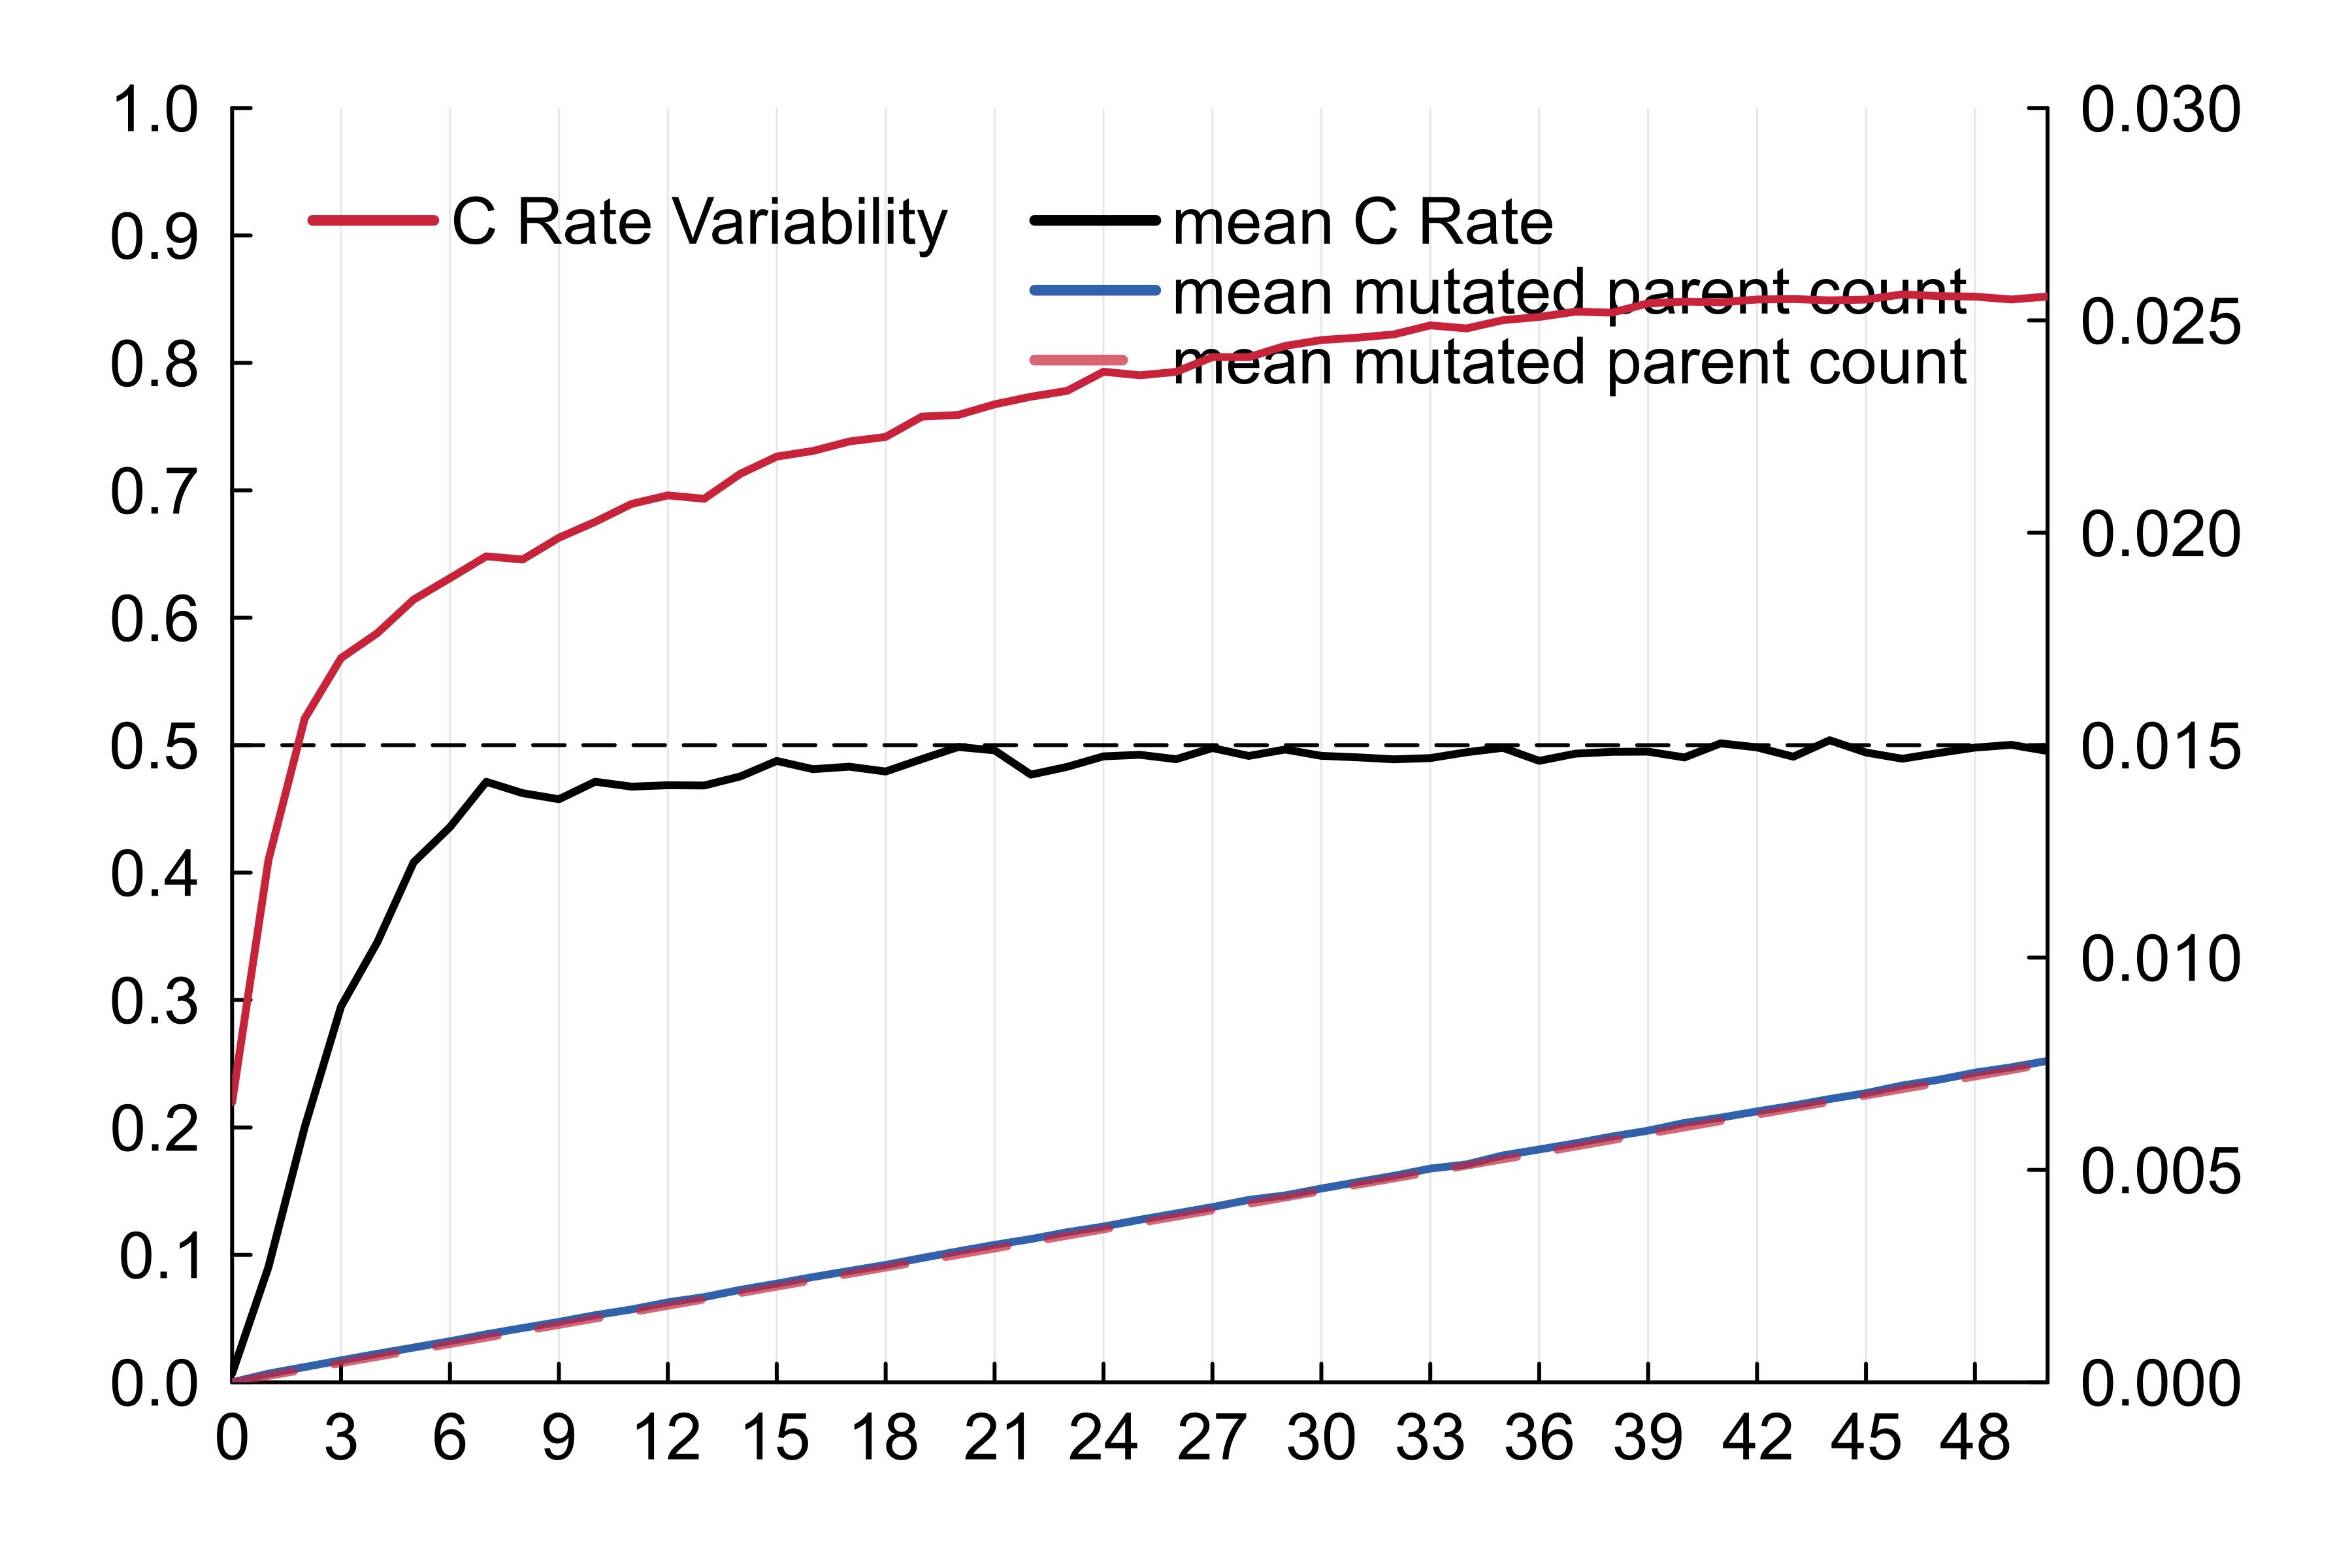

In [9]:
plot_σR_lines(collect(σR_vec), mean_C_rate_vec_1, mean_C_rate_var_vec_1, mean_mutated_parent_n_vec_1);

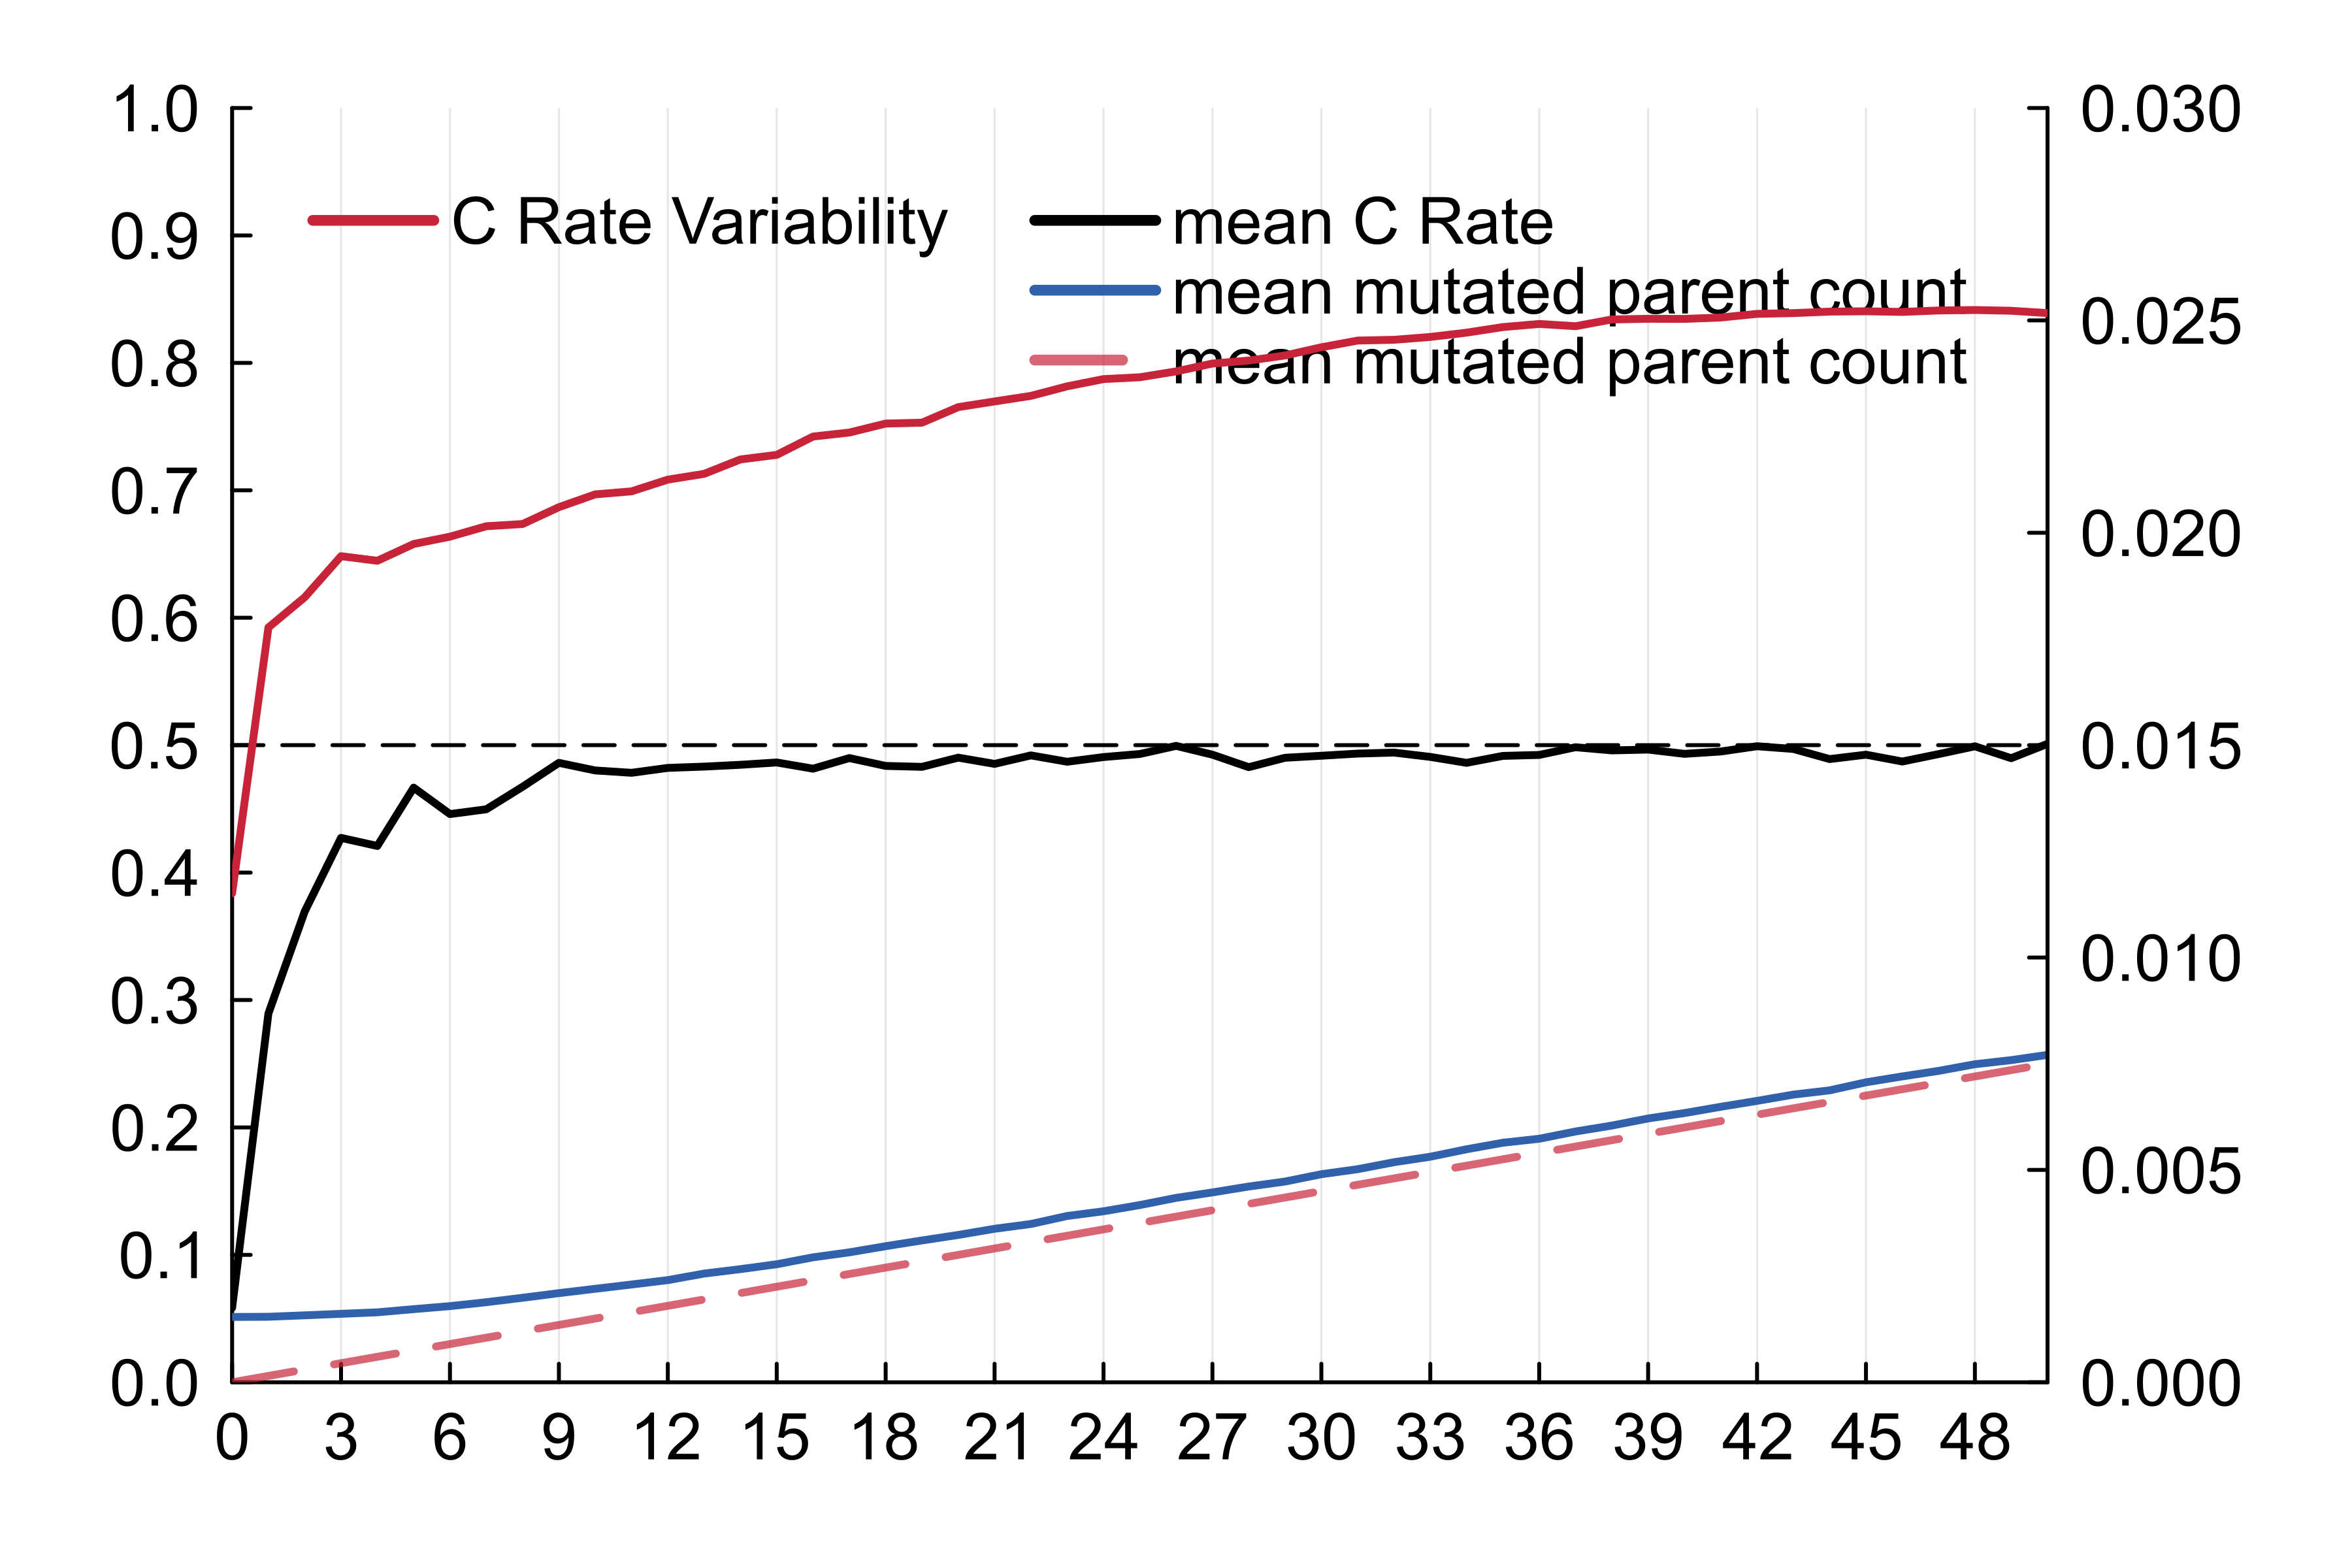

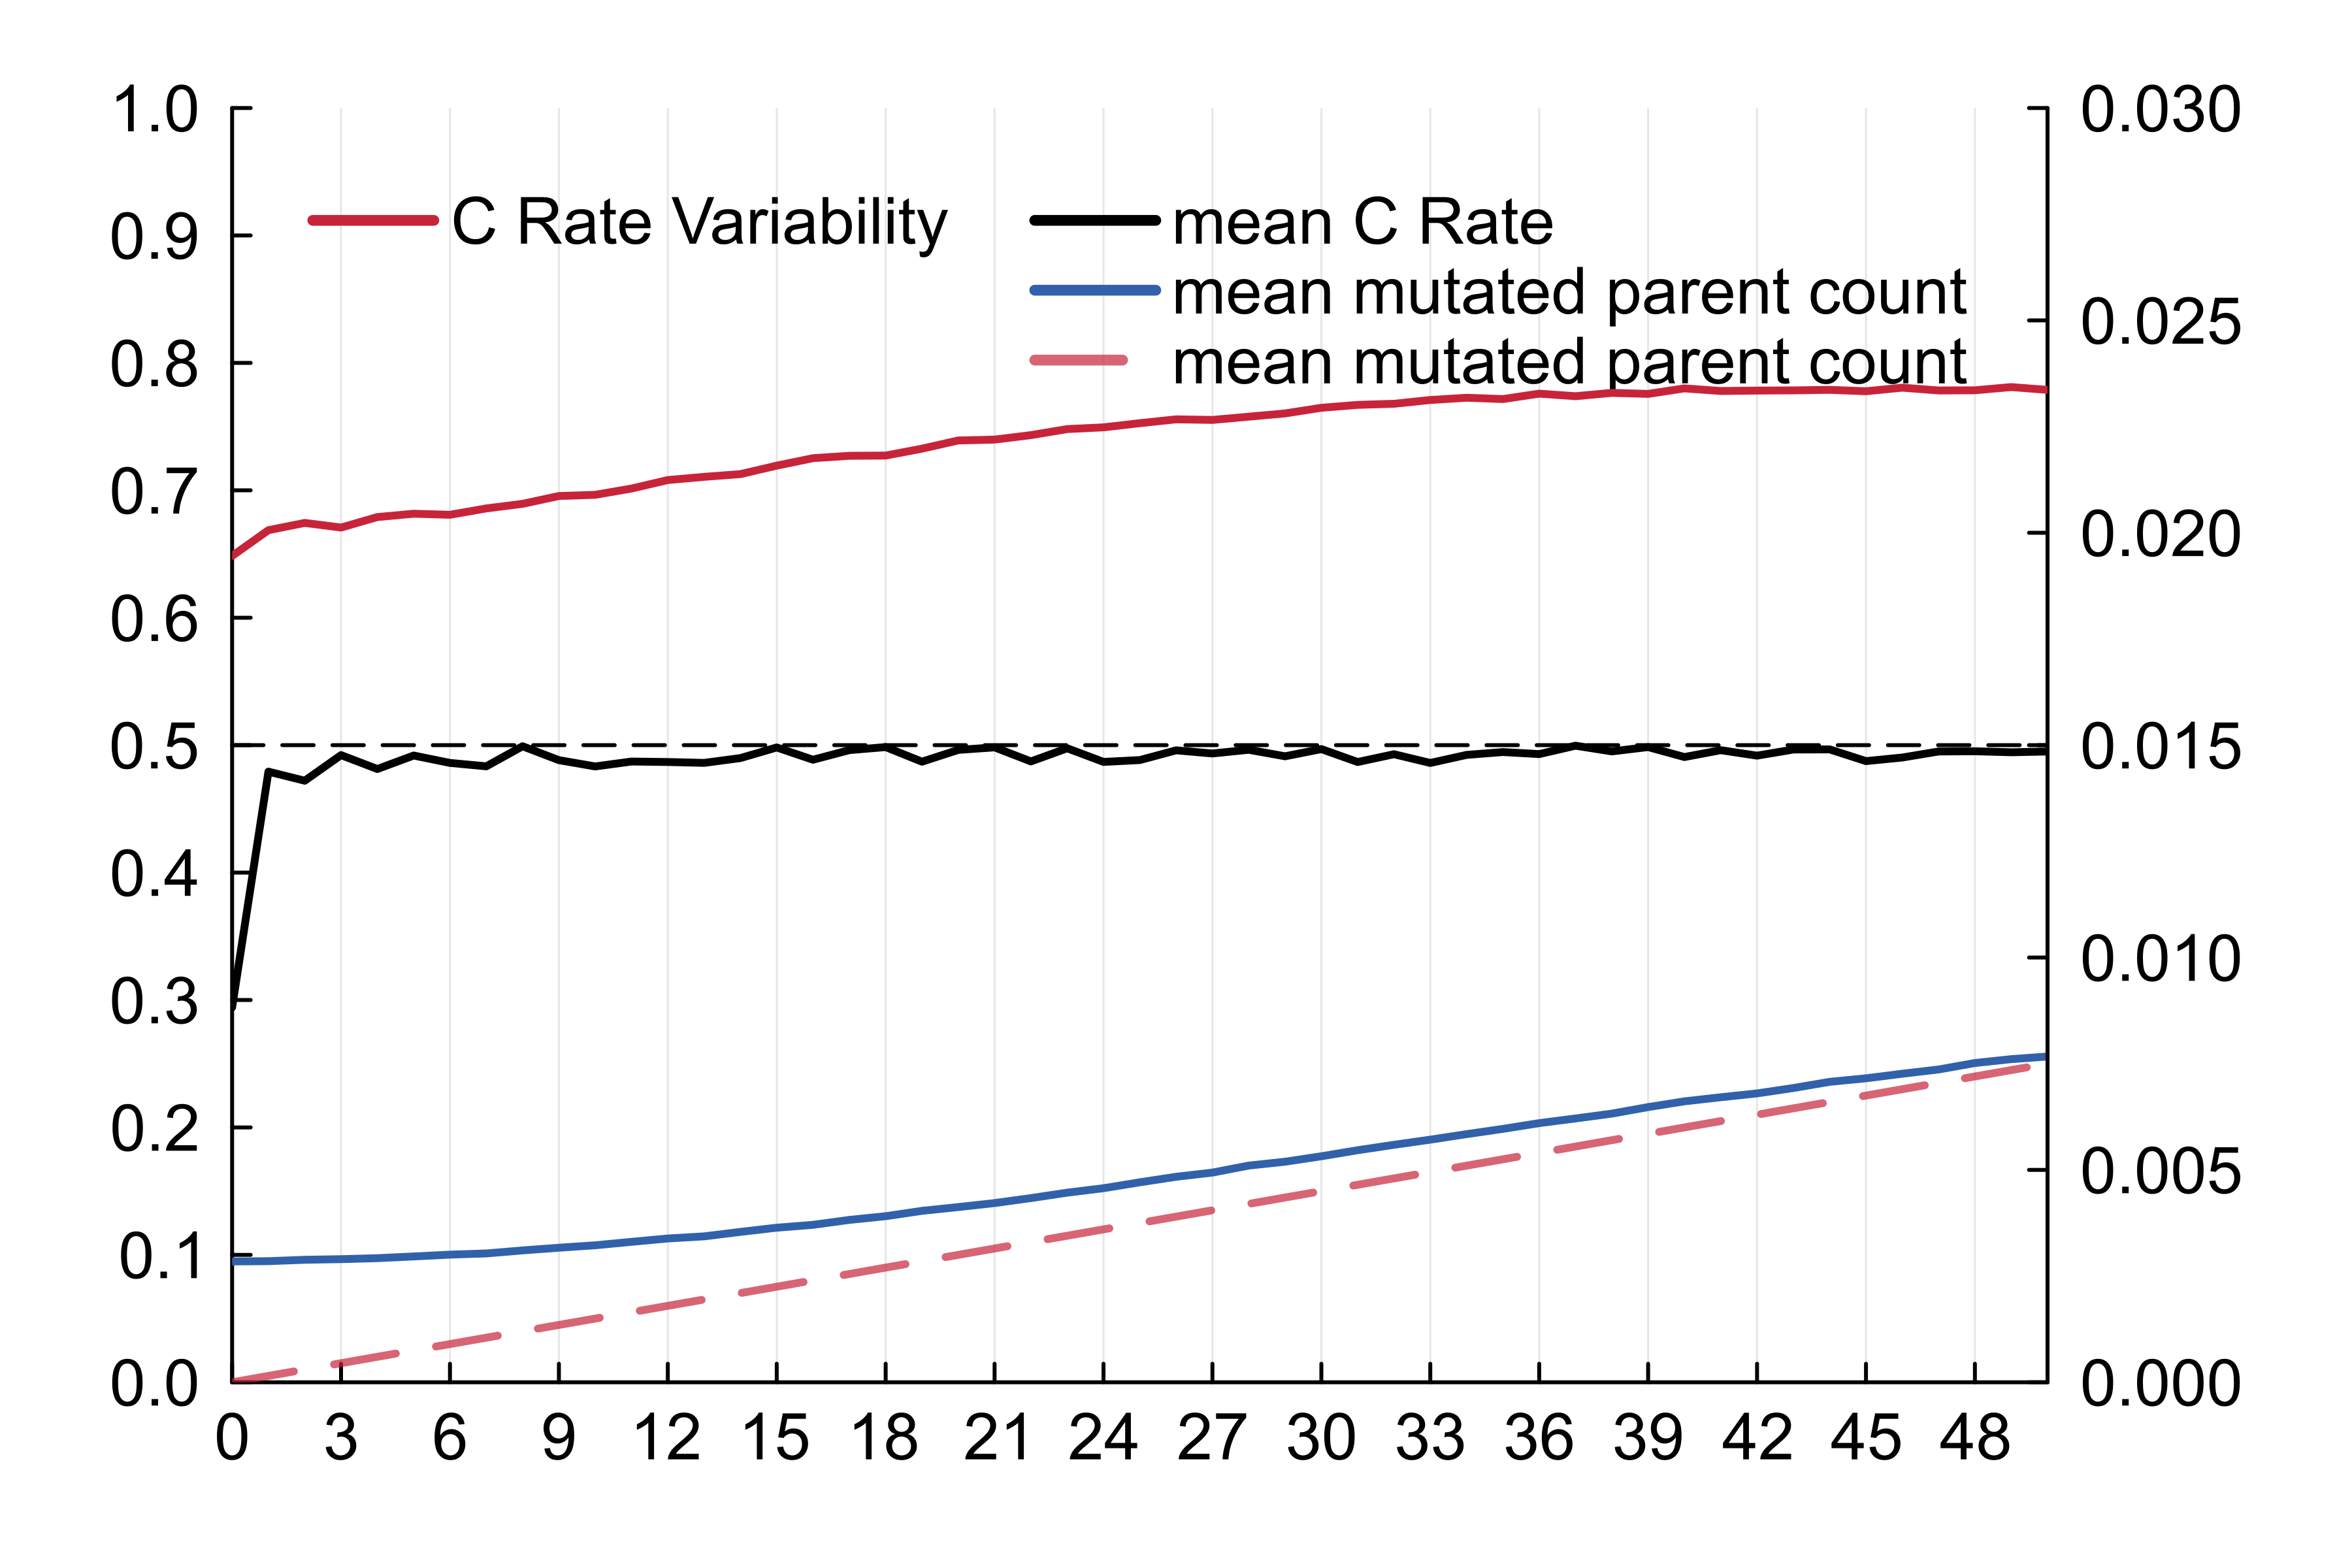

In [10]:
plot_σR_lines(collect(σR_vec), mean_C_rate_vec_4, mean_C_rate_var_vec_4, mean_mutated_parent_n_vec_4);
plot_σR_lines(collect(σR_vec), mean_C_rate_vec_5, mean_C_rate_var_vec_5, mean_mutated_parent_n_vec_5);

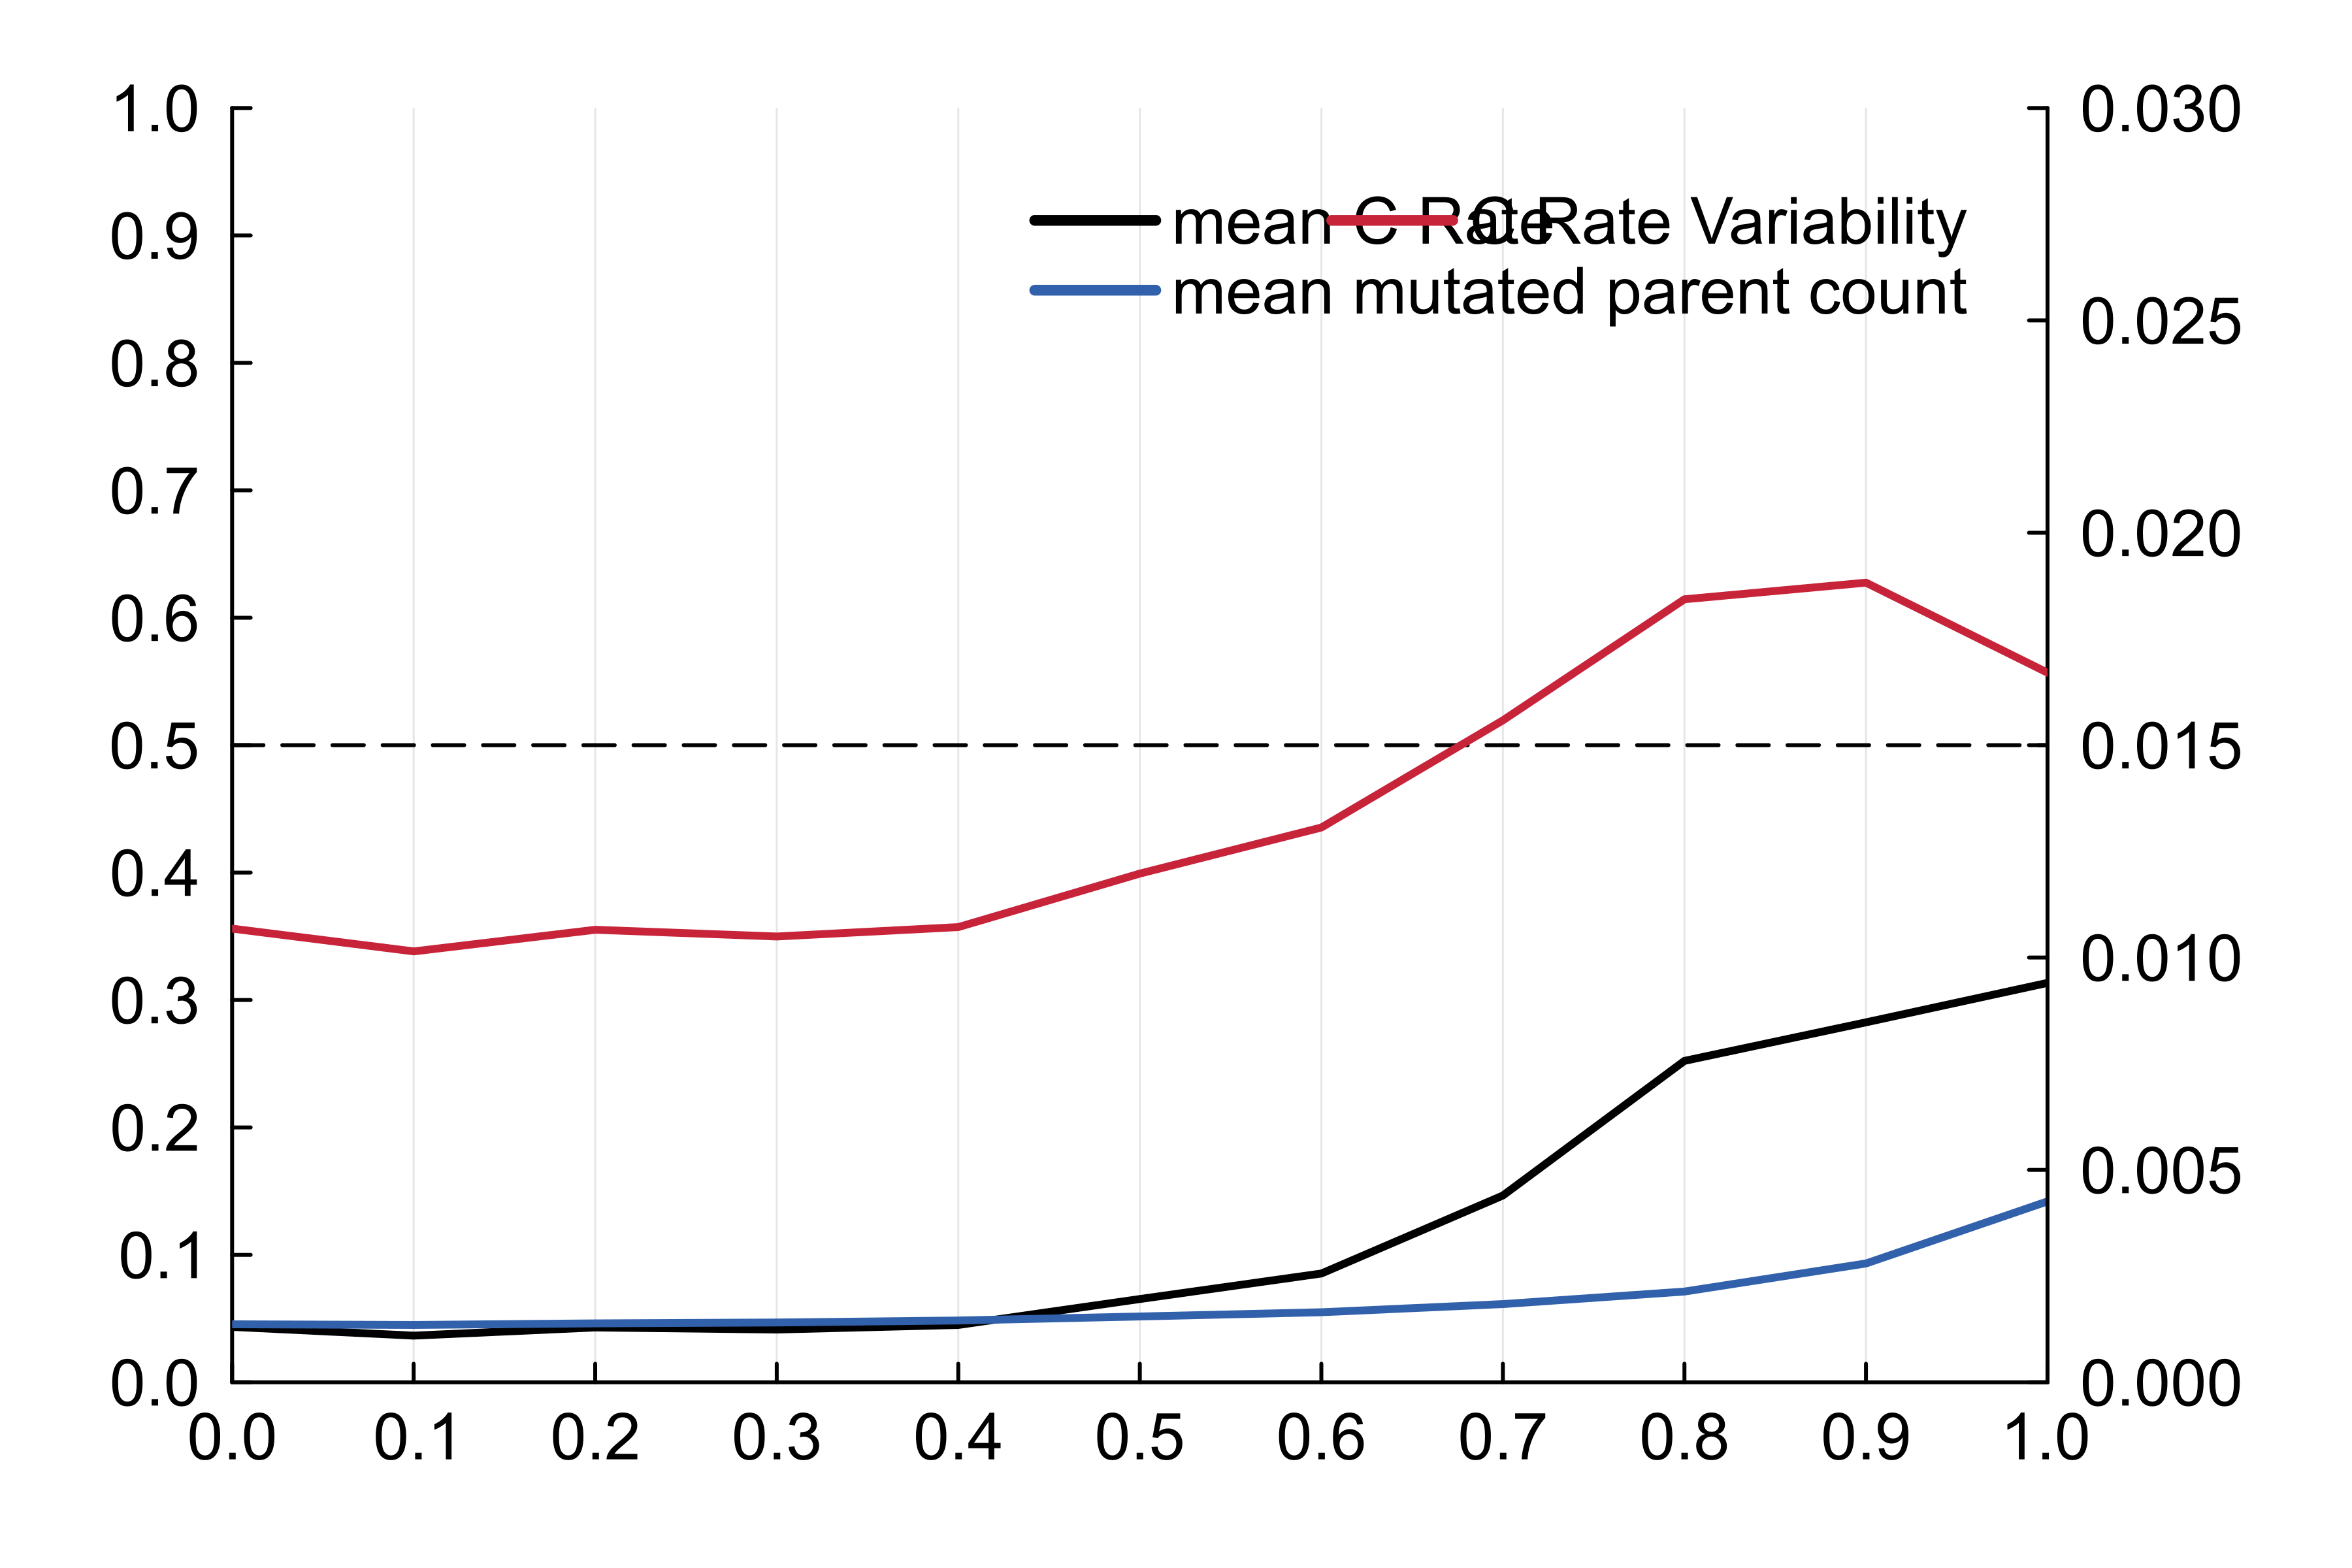

In [11]:
plot_β_lines(collect(β_vec), mean_C_rate_vec_2, mean_C_rate_var_vec_2, mean_mutated_parent_n_vec_2);

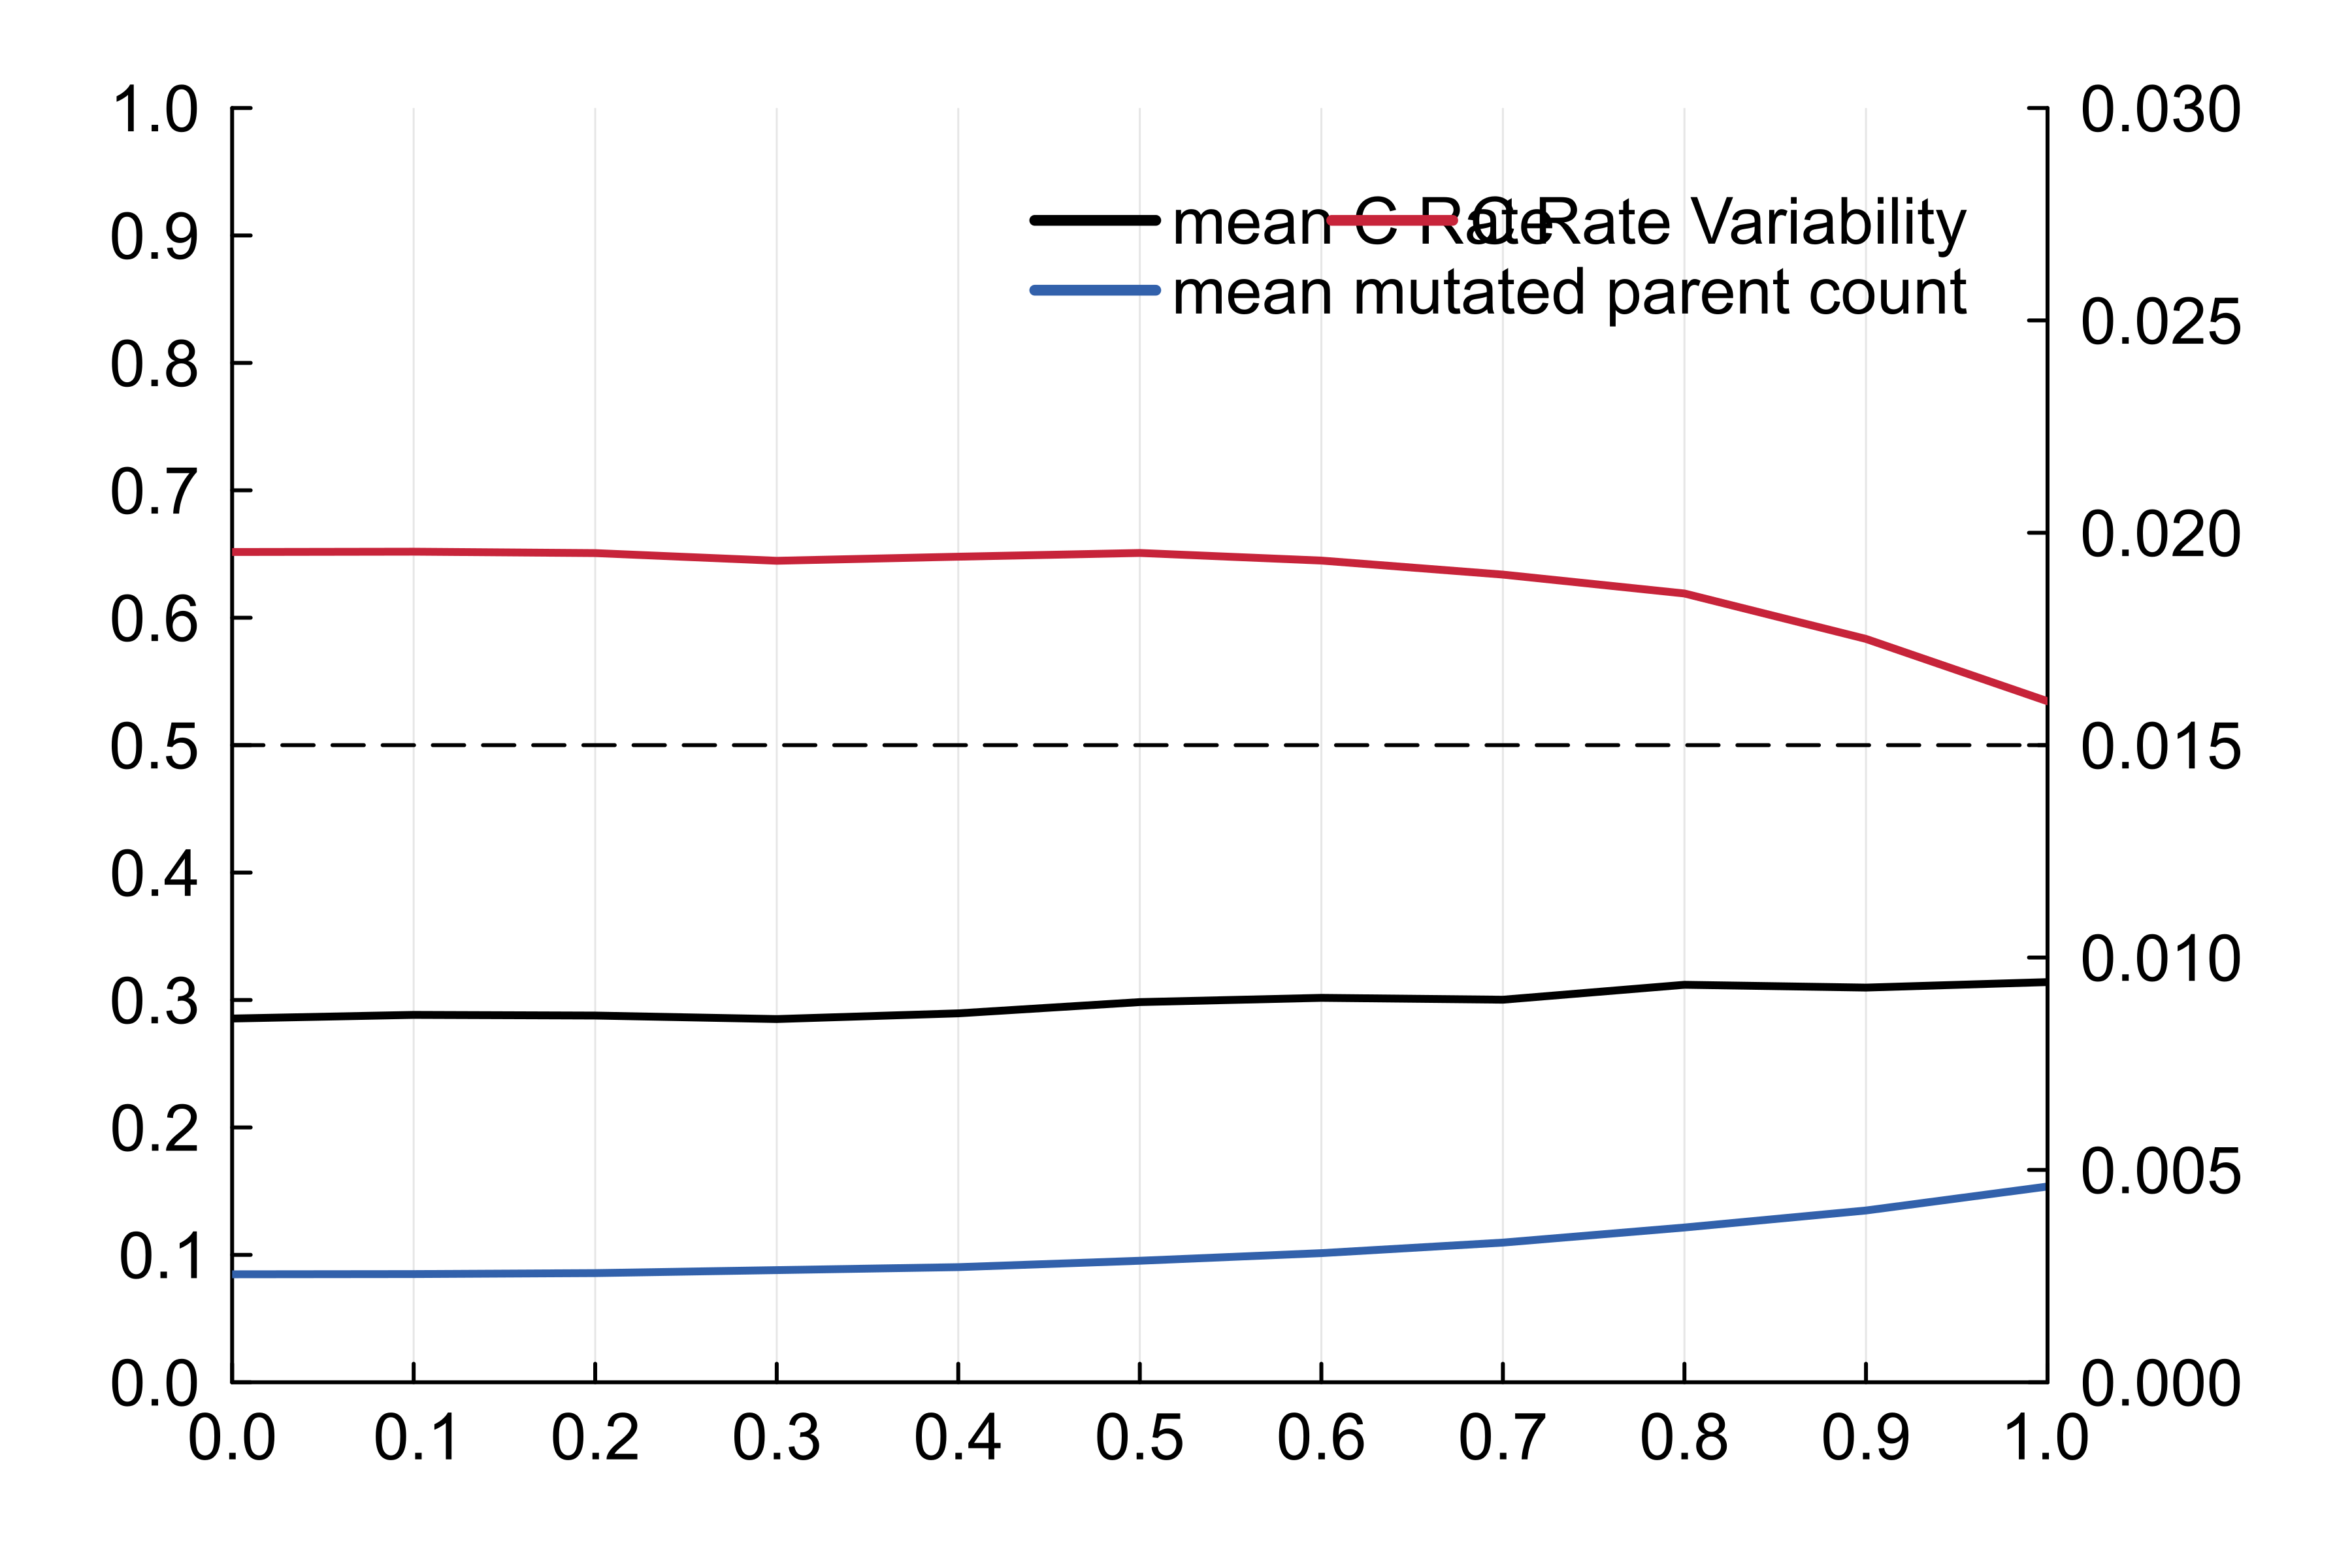

In [12]:
plot_β_lines(collect(β_vec), mean_C_rate_vec_3, mean_C_rate_var_vec_3, mean_mutated_parent_n_vec_3);

In [62]:
label1 = "RV"
label2 = "UV (\\sigma_{\\theta} = 0.1)"
label3 = "UV (\\sigma_{\\theta} = 0.2)"
label4 = "CV: (\\beta, \\sigma_{\\theta}) = (0.5, 0.1)"
label5 = "CV: (\\beta, \\sigma_{\\theta}) = (0.5, 0.2)"
xlabel1 = "\\sigma_{R} (for RV and CV)"
xlabel2 = "\\beta (for UV)"
ylabel = "Number of Mutated Role Models"
title = "Effect of EV without Game"
legend_x = 0.12
legend_y = 0.63
legend_space = 0.078;

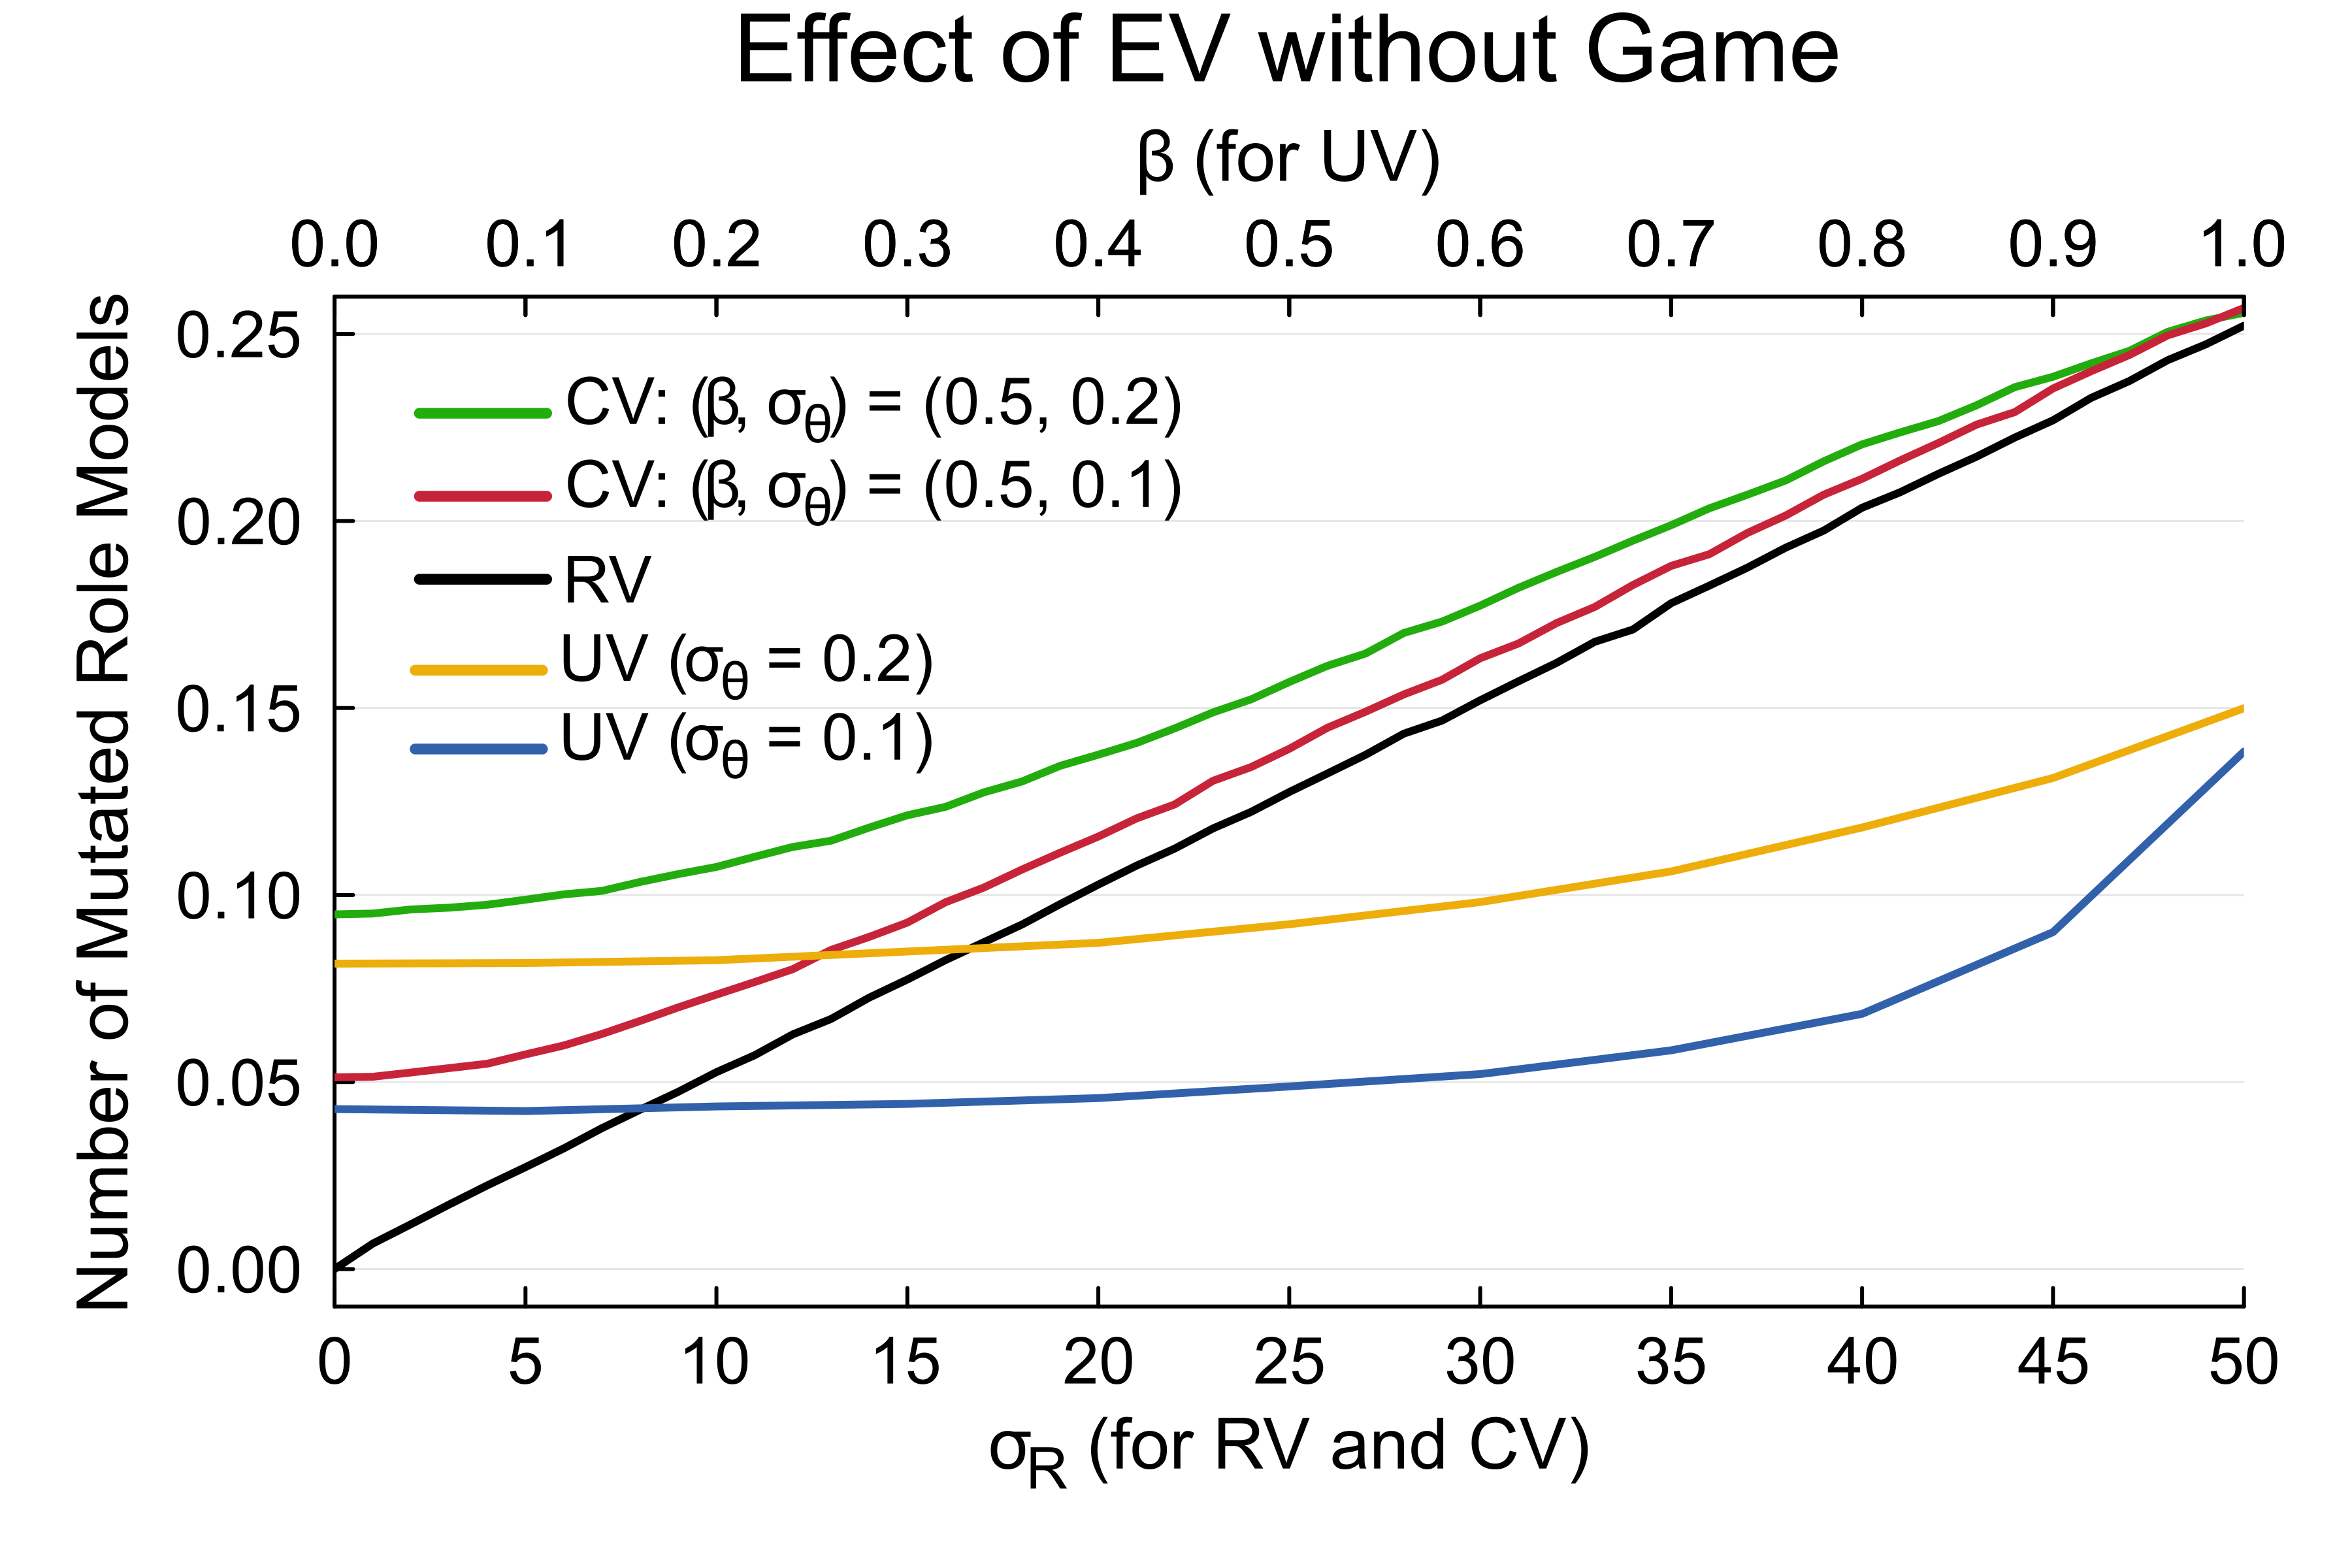

In [66]:
plt = plot(xlabel=xlabel1, ylim=(-0.01, 0.26), yticks=0:0.05:0.3, ylabel=ylabel, title=title, top_margin = 8Plots.mm)
plot!(σR_vec, mean_mutated_parent_n_vec_5, xlim=(0, 50), xticks=0:5:50, lc=CS.GREEN, label=label5)
plot!(σR_vec, mean_mutated_parent_n_vec_4, xlim=(0, 50), xticks=0:5:50, lc=CS.RED, label=label4)
plot!(σR_vec, mean_mutated_parent_n_vec_1, xlim=(0, 50), xticks=0:5:50, lc=CS.BLACK, label=label1)
plot!(twiny(), β_vec, mean_mutated_parent_n_vec_2, xlim=(0, 1), xticks=0:0.1:1, lc=CS.BLUE, label=label2, xlabel=xlabel2, legend=(legend_x, legend_y - legend_space))
plot!(twiny(), β_vec, mean_mutated_parent_n_vec_3, xlim=(0, 1), xticks=0:0.1:1, lc=CS.ORANGE, label=label3, legend=(legend_x, legend_y))
savefig("img/Fig5a.png")
display(plt);